In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zzettrkalpakbal/full-filled-brain-stroke-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset/versions/2


In [13]:
import os


print("Archivos en el dataset:", os.listdir(path))

Archivos en el dataset: ['full_filled_stroke_data (1).csv', 'full_data.csv']


In [14]:
# Accedo al dataset
file_path = os.path.join(path, "full_data.csv")  # Ajusta el nombre según el archivo real
df = pd.read_csv(file_path)

# Mostrar las primeras filas
display(df.sample(15))

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4,Male,81.00,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
198,Female,51.00,1,0,Yes,Private,Urban,88.20,28.4,never smoked,1
3547,Male,42.00,0,0,Yes,Govt_job,Rural,68.12,32.0,Unknown,0
789,Male,65.00,0,0,Yes,Self-employed,Rural,94.64,28.6,never smoked,0
2486,Male,15.00,0,0,No,Private,Urban,190.13,20.7,never smoked,0
909,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
4211,Female,75.00,1,0,Yes,Self-employed,Rural,197.06,26.1,never smoked,0
951,Female,15.00,0,0,No,Private,Rural,95.43,25.0,Unknown,0
656,Female,51.00,0,0,Yes,Self-employed,Rural,67.97,29.4,smokes,0
395,Female,65.00,0,0,Yes,Self-employed,Rural,104.21,36.8,never smoked,0


In [15]:
# Separar variables predictoras y target
X = df.drop(columns=['stroke'])
y = df['stroke']


In [16]:
# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

In [17]:

# Aplicar SMOTE para balancear las clases
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [18]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

In [19]:
# Estandarización de variables numéricas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Entrenar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [21]:
# Entrenar XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Ajustar umbral de decisión en XGBoost
prob_threshold = 0.3  # Reducimos el umbral para mejorar recall
y_pred_xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_pred_xgb_prob > prob_threshold).astype(int)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:34:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluación de Random Forest con SMOTE:
Accuracy: 0.9514
Precision: 0.9410
Recall: 0.9112
F1-Score: 0.9259
Matriz de Confusión:
[[920  27]
 [ 42 431]]


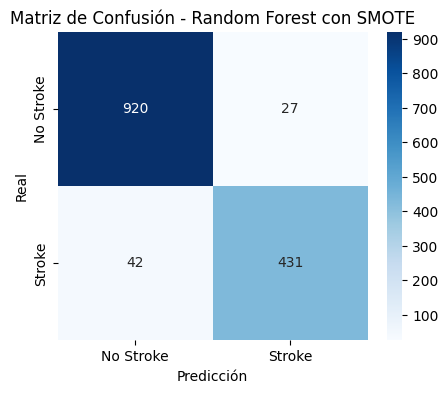


Evaluación de XGBoost con SMOTE y umbral ajustado:
Accuracy: 0.9359
Precision: 0.8790
Recall: 0.9366
F1-Score: 0.9069
Matriz de Confusión:
[[886  61]
 [ 30 443]]


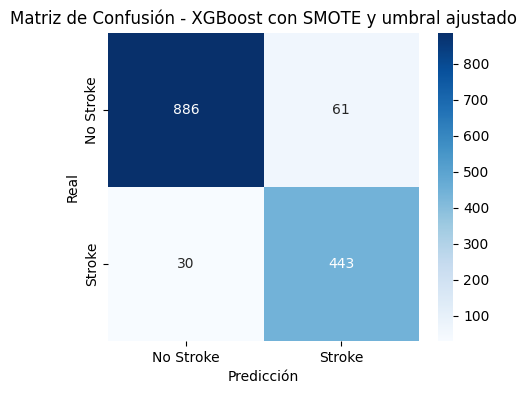

In [23]:

# Función para calcular métricas
def evaluar_modelo(y_true, y_pred, nombre_modelo):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"\nEvaluación de {nombre_modelo}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Matriz de Confusión:")
    print(conf_matrix)

    # Graficar matriz de confusión
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()


# Evaluar ambos modelos
evaluar_modelo(y_test, y_pred_rf, "Random Forest con SMOTE")
evaluar_modelo(y_test, y_pred_xgb, "XGBoost con SMOTE y umbral ajustado")


# Cómo interpretar los valores

##**Verdaderos Negativos (VN): Casos donde el modelo predijo correctamente "No".**

##**Falsos Positivos (FP): Casos donde el modelo predijo "Sí" pero en realidad era "No" (Error Tipo I).**

##**Falsos Negativos (FN): Casos donde el modelo predijo "No" pero en realidad era "Sí" (Error Tipo II).**

##**Verdaderos Positivos (VP): Casos donde el modelo predijo correctamente "Sí".**

#Ejemplo con XGBoost:

## **VN = 886: "No"  Que son correctos.**

## **FP = 61: "No" erroneamente clasificados como "Sí".**

## **FN = 30: "Sí" erroneamente clasificados como "No".**

## **VP = 443: "Sí" correctos.**

# Análisis de los modelos:
##✅ Random Forest con SMOTE

**Precisión alta (0.9410) → Muy pocas falsas alertas.**

**Recall alto (0.9112) → Detecta la mayoría de los casos positivos.**

**F1-score alto (0.9259) → Buen equilibrio entre precisión y recall.**

##✅ XGBoost con SMOTE y umbral ajustado

**Menos precisión (0.8790) → Más falsos positivos que Random Forest.**

**Mayor recall (0.9366) → Detecta aún más casos positivos.**

**F1-score sólido (0.9069) → Buen rendimiento general.**

# ¿Cuál es mejor?

## Si querés minimizar falsos positivos, Random Forest es la mejor opción.

## Si priorizás detectar más casos positivos, XGBoost con umbral ajustado es mejor